# Imports

In [2]:
import json
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import List, Mapping

In [3]:
MODEL_NAME = "cointegrated/rubert-tiny"

In [4]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [5]:
filename = "../data/train-v1.1.json"

In [6]:
with open(filename, "r") as fh:
    source = json.load(fh)

In [7]:
source["data"][0]["paragraphs"][0]

{'context': 'В допетровское время искусство в России имело своим призванием служить исключительно религиозным целям, а так как православная церковь гнушается изваяниями человеческих фигур, то скульптура, в настоящем смысле слова, не могла в древней Руси не только развиваться, но и существовать. Правда, в некоторых местах, в особенности в бывших новгородских областях, пользовались уважением резные и раскрашенные изображения святых, но они были чужды всякого художественного значения и составляли изделия, возникшие под влиянием Запада. Собственно же на Руси проявления пластики ограничивались литьем небольших крестов, образов-складней, выбиванием окладов на образа и резьбою фигурных иконостасов. В числе плодов западно-европейской цивилизации Пётр Великий перенес в него и скульптуру, которая, однако, при этом государе и долго после него находилось здесь в руках приезжих иностранцев. Главным деятелем по части скульптуры в царствование Петра Великого и Анны Иоанновны был К. Б. Растрелли, отец

In [8]:
source["data"][0]["paragraphs"][0]['context'][583:]

'литьем небольших крестов, образов-складней, выбиванием окладов на образа и резьбою фигурных иконостасов. В числе плодов западно-европейской цивилизации Пётр Великий перенес в него и скульптуру, которая, однако, при этом государе и долго после него находилось здесь в руках приезжих иностранцев. Главным деятелем по части скульптуры в царствование Петра Великого и Анны Иоанновны был К. Б. Растрелли, отец знаменитого впоследствии архитектора, вызванный в Петербург для литья пушек. Об его манерном стиле свидетельствуют бронзовая статуя императрицы Анны, и монумент Петру Великому, стоящий перед Инженерным замком в Санкт-Петербурге.'

In [9]:
input_ids = tokenizer.encode(source["data"][0]["paragraphs"][0]['context'])
# tokenizer.convert_ids_to_tokens(input_ids)

In [10]:
tokenizer(source["data"][0]["paragraphs"][0]['context']).char_to_token(1200)

352

In [11]:
answer_ids = tokenizer.encode(source["data"][0]["paragraphs"][0]['qas'][0]['answers'][0]['text'])

In [12]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))

    return results

In [13]:
find_sub_list(answer_ids[1:-1], input_ids)

[(160, 199)]

In [14]:
' '.join(tokenizer.convert_ids_to_tokens(input_ids[160: 199])).replace(' ##', '')

'литьем небольших крестов , образов - складней , выбиванием окладов на образа и резьбою фигурных иконостасов'

# Подготовка датасета

In [15]:
source["data"][0]["paragraphs"][0]['qas'][0]['answers'][0]['text']

'литьем небольших крестов, образов-складней, выбиванием окладов на образа и резьбою фигурных иконостасов.'

In [16]:
with open(filename, "r") as fh:
    source = json.load(fh)

In [17]:
tokenizer.convert_tokens_to_ids("[SEP]")

3

In [18]:
train_dict = {
    "text": [],
    "start": [],
    "end": []
}

for article in source["data"]:
    for para in article["paragraphs"]:
        for qa in para["qas"]:
            train_dict["text"].append(para["context"] + "[SEP]" + qa["question"])
            train_dict["start"].append(qa["answers"][0]["answer_start"])
            train_dict["end"].append(qa["answers"][0]["answer_start"] + len(qa["answers"][0]["text"]))
            if len(qa["answers"]) > 1:
                print("here")

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.DataFrame(train_dict)

In [21]:
df["text_len"] = df["text"].apply(lambda x: len(x))
text_lens = df["text_len"].value_counts()

<AxesSubplot:>

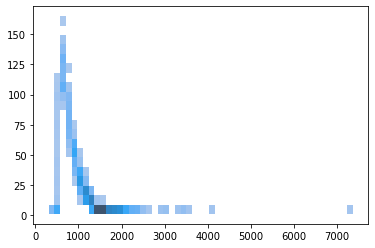

In [22]:
sns.histplot(x=text_lens.index, y=text_lens.values)

In [23]:
mask = text_lens.index > 1500
text_lens[mask].sum()

843

In [24]:
df = df[df["text_len"] < 1500]

In [25]:
df.shape

(44485, 4)

In [26]:
df.head()

,text,start,end,text_len
0,В допетровское время искусство в России имело ...,583,687,1268
1,По данным рейтинга Top 100 самых филиальных ба...,115,122,979
2,Смарт-стекло — современный собирательный терми...,205,215,812
3,Во время интервенции в Россию Речи Посполитой ...,287,300,865
4,В начале 1823 года Грибоедов на время покинул ...,9,13,740


In [62]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """
    def __init__(self,
                 texts: List[str],
                 start: List[int] = None,
                 end: List[int] = None,
                 label_dict: Mapping[str, int] = None,
                 max_seq_length: int = 512,
                 model_name: str = 'distilbert-base-uncased'):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization

        """

        self.texts = texts
        self.start = start
        self.end = end
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

#         if self.label_dict is None and labels is not None:
#             # {'class1': 0, 'class2': 1, 'class3': 2, ...}
#             # using this instead of `sklearn.preprocessing.LabelEncoder`
#             # no easily handle unknown target values
#             self.label_dict = dict(zip(sorted(set(labels)),
#                                        range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
#         logging.getLogger(
#             "transformers.tokenization_utils").setLevel(logging.FATAL)

        # special tokens for transformers
        # in the simplest case a [CLS] token is added in the beginning
        # and [SEP] token is added in the end of a piece of text
        # [CLS] <indexes text tokens> [SEP] .. <[PAD]>
        self.sep_vid = self.tokenizer.vocab["[SEP]"]
        self.cls_vid = self.tokenizer.vocab["[CLS]"]
        self.pad_vid = self.tokenizer.vocab["[PAD]"]

    def __len__(self):
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        # encoding the text
        x = self.texts[index]
        x_encoded = self.tokenizer(
            x,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
        )
        input_ids = x_encoded["input_ids"].squeeze(0)
        # padding short texts
        true_seq_length = input_ids.size(0)
        pad_size = self.max_seq_length - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        x_tensor = torch.cat((input_ids, pad_ids))

        # dealing with attention masks - there's a 1 for each input token and
        # if the sequence is shorter that `max_seq_length` then the rest is
        # padded with zeroes. Attention mask will be passed to the model in
        # order to compute attention scores only with input data
        # ignoring padding
        mask = torch.ones_like(input_ids, dtype=torch.int8)
        mask_pad = torch.zeros_like(pad_ids, dtype=torch.int8)
        mask = torch.cat((mask, mask_pad))
        start_token_idx = x_encoded.char_to_token(self.start[index])
        end_token_idx = x_encoded.char_to_token(self.end[index]) if x_encoded.char_to_token(self.end[index]) is not None else x_encoded.char_to_token(self.end[index] + 1),
#         start_ohe = torch.zeros(self.max_seq_length)
#         start_ohe[start_token_idx] = 1
#         end_ohe = torch.zeros(self.max_seq_length)
#         end_ohe[end_token_idx] = 1
        output_dict = {
            "features": x_tensor,
            "attention_mask": mask,
            "start_token": start_token_idx,
            "end_token": end_token_idx,           
        }

        # encoding target
#         if self.labels is not None:
#             y = self.labels[index]
#             y_encoded = torch.Tensor(
#                 [self.label_dict.get(y, -1)]
#             ).long().squeeze(0)
#             output_dict["targets"] = y_encoded

        return output_dict

In [63]:
MAX_SEQ_LENGTH = 512

In [64]:
train_dataset = TextClassificationDataset(
    texts=df['text'].values.tolist(),
    start=df['start'].values.tolist(),
    end=df['end'].values.tolist(),
    label_dict=None,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

### Checks

In [65]:
sample = train_dataset.__getitem__(5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [66]:
sample["start_token"], sample["end_token"]

(162, (167,))

In [67]:
# tokenizer.convert_ids_to_tokens(sample["features"][sample["start_token"]:sample["end_token"]])

In [68]:
source["data"][0]["paragraphs"][5]["qas"][0]["answers"]

[{'answer_start': 535, 'text': 'Якоб Гримм'}]

## Create dataloader

In [69]:
BATCH_SIZE = 2

In [70]:
train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

In [71]:
mini_batch = next(iter(train_dataloader))

# get_model

In [72]:
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
model(mini_batch['features'])[0].shape

torch.Size([2, 512, 312])

In [39]:
model(mini_batch['features']).last_hidden_state.shape

torch.Size([2, 512, 312])

In [40]:
torch.all((model(mini_batch['features'])[0].eq(model(mini_batch['features']).last_hidden_state)))

tensor(True)

In [41]:
output = model(mini_batch['features'], mini_batch['attention_mask']).last_hidden_state

In [42]:
linear = nn.Linear(312, 2)

In [43]:
logits = linear(output)

In [44]:
start_logits, end_logits = logits.split(1, dim=-1)
start_logits = start_logits.squeeze(-1).contiguous()
end_logits = end_logits.squeeze(-1).contiguous()

In [45]:
ignored_index = start_logits.size(1)

In [46]:
# start_logits.clamp(0, 10)[0]

In [47]:
start_logits.shape, end_logits.shape

(torch.Size([2, 512]), torch.Size([2, 512]))

In [48]:
start_logits.shape, mini_batch["start_token"].shape

(torch.Size([2, 512]), torch.Size([2, 512]))

In [49]:
from torch.nn import CrossEntropyLoss

In [50]:
criterion = CrossEntropyLoss(ignore_index=5)

In [51]:
start_logits

tensor([[-0.4696, -0.1763,  0.4592,  ...,  0.3961,  0.3349,  0.2292],
        [-0.7602,  0.1154, -0.1377,  ...,  0.2073,  0.1359,  0.0869]],
       grad_fn=<CopyBackwards>)

In [52]:
target = torch.tensor([5, 10])

In [53]:
criterion(start_logits, target)

tensor(5.8113, grad_fn=<NllLossBackward>)

In [54]:
torch.nn.functional.softmax(start_logits[0], dim=-1).argmax()

tensor(174)

In [ ]:
123

## model class

In [77]:
class BertForQuestionAnswering(nn.Module):
    

    def __init__(self):
        super().__init__()
        self.num_labels = 2

        self.bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")#BertModel(config, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(312, self.num_labels)

#         self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        start_positions=None,
        end_positions=None,
    ):


        outputs = self.bert(input_ids, attention_mask)
    
        sequence_output = outputs.last_hidden_state
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()
        
        return start_logits, end_logits


In [78]:
model_qa = BertForQuestionAnswering()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
out = model_qa(mini_batch['features'], mini_batch['attention_mask'])

In [3]:
criterion = nn.CrossEntropyLoss()

In [82]:
criterion(out[0], mini_batch['start_token'])

tensor(6.7900, grad_fn=<NllLossBackward>)

In [87]:
criterion(out[1], mini_batch['end_token'][0])

tensor(6.1443, grad_fn=<NllLossBackward>)

# end

In [57]:

criterion = nn.CrossEntropyLoss()

output = torch.randn(10, 120).float()
target = torch.FloatTensor(10).uniform_(0, 120).long()

loss = criterion(output, target)

In [58]:
output.shape, target.shape

(torch.Size([10, 120]), torch.Size([10]))

In [59]:
output

tensor([[ 1.3253, -0.2134,  0.8089,  ...,  0.3965, -0.4740,  0.6075],
        [ 0.7365,  1.2239,  1.5120,  ..., -0.6894, -1.1235, -1.2199],
        [ 0.3554, -0.1627,  0.6680,  ..., -1.3083,  0.1721, -0.3332],
        ...,
        [ 1.3723, -1.2871,  0.0656,  ...,  0.5257,  1.5737,  0.9170],
        [-0.2345,  0.7721, -0.1130,  ..., -0.6746, -2.7554,  0.7493],
        [ 0.0654, -0.4041,  1.2042,  ...,  0.2530,  0.6490,  0.8605]])

In [60]:
df.loc[0]

text        В допетровское время искусство в России имело ...
start                                                     583
end                                                       687
text_len                                                 1268
Name: 0, dtype: object

In [61]:
x_encoded = tokenizer(
    source["data"][0]["paragraphs"][0]['context'],
    add_special_tokens=True,
    max_length=312,
    return_tensors="pt",
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [62]:
x_encoded.char_to_token(584)

160

In [63]:
x_encoded.input_ids.shape

torch.Size([1, 312])

In [64]:
for p in model.parameters():
    p.requires_grad = False